In [23]:
import pandas as pd
import numpy as np

import os

In [24]:
data_path = os.getcwd() + "/dataset/total_concentrated.csv"
# features = ["A_F", "A_V", "A_L", "L_F", "L_T", "L_L", "T_F", "T_V", "T_L"]

dataset = pd.read_csv(data_path)
time = list(dataset['time'])

TFdata = dataset[["T_F"]].values
TVdata = dataset[["T_V"]].values
TLdata = dataset[["T_L"]].values

dataframe = dataset[["T_F", "T_V", "T_L"]].values
dataset = dataset[["T_F", "T_V", "T_L", "Action"]].values

window_length = int(1*64)
total_windows = int((len(dataset))/window_length)

In [25]:
TFdata = np.array(TFdata)
TVdata = np.array(TVdata)
TLdata = np.array(TLdata)

In [26]:
Tsensor = np.multiply(TFdata, TFdata) + np.multiply(TVdata, TVdata) + np.multiply(TLdata, TLdata)

In [27]:
Tsensor = np.sqrt(Tsensor)

In [28]:
dataframe = (dataframe-dataframe.mean())/dataframe.std()
Tsensor = (Tsensor-Tsensor.mean())/Tsensor.std()

In [29]:
indices = time
groups = []
group_count = 0
temp = []
lenOfGroup = []
length_count = 0

for i in range(len(indices)):
    if i == (len(indices) - 1):
        temp.append(indices[i])
        length_count = length_count + 1

        groups.append(temp)
        lenOfGroup.append(length_count)
        length_count = 0
        temp = []
        break
    temp.append(indices[i])
    length_count = length_count + 1
    if (indices[i+1] - 20 > indices[i]):
        group_count = group_count + 1

        lenOfGroup.append(length_count)
        length_count = 0

        groups.append(temp)
        temp = []

del temp, indices, group_count, length_count, i

In [30]:
countOfUndivisible = 0
total_windows_with_overlap = 0

start_index = 0

stop_Indexs = []
stop_Index = -window_length


for lengths in lenOfGroup:
    stop_Index = stop_Index + lengths
    stop_Indexs.append(stop_Index)
    total_windows_with_overlap = total_windows_with_overlap + int(lengths/window_length*2 -1)
    
    if lengths % (window_length/2) != 0:
        countOfUndivisible = countOfUndivisible + 1
        print(lengths)

print(countOfUndivisible)
del countOfUndivisible, lengths

0


In [35]:
X_ = np.empty((total_windows_with_overlap, window_length))
y_ = np.empty((total_windows_with_overlap, 1))

stop_Index = 0
window_count = 0

for window in range(total_windows_with_overlap):
    for i in range(window_length):
        if i == 0:
            y_[window] = dataset[int(window_count*window_length), 3]
        
        if int(window_count*window_length)<len(dataset)-window_length-1:
            X_[window, i] = Tsensor[int(window_count*window_length) + i]
        
        if stop_Index < len(stop_Indexs):
            if int(window_count*window_length) == stop_Indexs[stop_Index]:
                window_count = window_count + 0.5
                stop_Index = stop_Index + 1

        if window == total_windows_with_overlap-1:
            X_[window, i] = Tsensor[int((window_count-0.5)*window_length) + i]
    window_count = window_count + 0.5

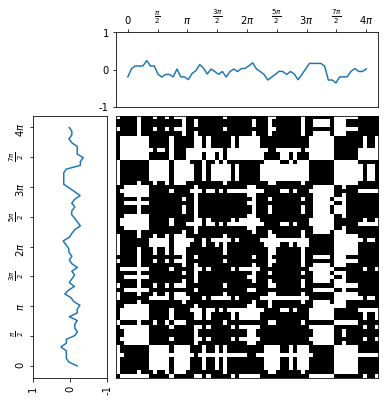

In [39]:
# Create a toy time series using the sine function
time_points = np.linspace(0, 4 * np.pi, 64)
x = X_[0]
X = np.array([x])

# Recurrence plot transformation
rp = RecurrencePlot(threshold=np.pi/18)
X_rp = rp.transform(X)

# Plot the time series and its recurrence plot
fig = plt.figure(figsize=(6, 6))

gs = fig.add_gridspec(2, 2,  width_ratios=(2, 7), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

# Define the ticks and their labels for both axes
time_ticks = np.linspace(0, 4 * np.pi, 9)
time_ticklabels = [r'$0$', r'$\frac{\pi}{2}$', r'$\pi$',
                   r'$\frac{3\pi}{2}$', r'$2\pi$', r'$\frac{5\pi}{2}$',
                   r'$3\pi$', r'$\frac{7\pi}{2}$', r'$4\pi$']
value_ticks = [-1, 0, 1]
reversed_value_ticks = value_ticks[::-1]

# Plot the time series on the left with inverted axes
ax_left = fig.add_subplot(gs[1, 0])
ax_left.plot(x, time_points)
ax_left.set_xticks(reversed_value_ticks)
ax_left.set_xticklabels(reversed_value_ticks, rotation=90)
ax_left.set_yticks(time_ticks)
ax_left.set_yticklabels(time_ticklabels, rotation=90)
ax_left.invert_xaxis()

# Plot the time series on the top
ax_top = fig.add_subplot(gs[0, 1])
ax_top.plot(time_points, x)
ax_top.set_xticks(time_ticks)
ax_top.set_xticklabels(time_ticklabels)
ax_top.set_yticks(value_ticks)
ax_top.set_yticklabels(value_ticks)
ax_top.xaxis.tick_top()

# Plot the recurrence plot on the bottom right
ax_rp = fig.add_subplot(gs[1, 1])
ax_rp.imshow(X_rp[0], cmap='binary', origin='lower',
             extent=[0, 4 * np.pi, 0, 4 * np.pi])
ax_rp.set_xticks([])
ax_rp.set_yticks([])

plt.show()

In [45]:
from pyts.image import RecurrencePlot
import matplotlib.pyplot as plt
save_path = os.getcwd() + "/dataset/RP/"
rp = RecurrencePlot()

for i in range(total_windows_with_overlap):
    final_path = save_path + str(int(y_[i]))
    x = X_[i]
    X = np.array([x])
    X_rp = rp.transform(X)

    fig = plt.figure(figsize=(1, 1))
    ax_rp = fig.add_subplot()
    ax_rp.imshow(X_rp[0], cmap='binary', origin='lower')
    ax_rp.set_xticks([])
    ax_rp.set_yticks([])

    image_path = final_path + '/' + str(i) + '.png'
    plt.savefig(image_path, bbox_inches='tight')
    plt.close(fig)

c:\Users\ESA LAB\anaconda3\envs\HighHeel\lib\site-packages\pydot.py:17: UserWarning: `pydot` could not import `dot_parser`, so `pydot` will be unable to parse DOT files. The error was:  No module named 'pyparsing'
  warnings.warn(
